### Apply the tracer inversion method

In [1]:
# interactive figure
%matplotlib widget
# %matplotlib inline

In [2]:
# auto reload modules
%load_ext autoreload
%autoreload 2

import os
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.ticker as tkr
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap, CenteredNorm, BoundaryNorm
from numpy.linalg import pinv
from sys import platform
from xgcm import Grid
from dask.distributed import LocalCluster, Client
from dask.diagnostics import ProgressBar
from dask_jobqueue import PBSCluster
from IPython.display import HTML, display
from viztool import FormatScalarFormatter
from streamjoy import stream, wrap_matplotlib

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

def fxn():
    warnings.warn('deprecated', DeprecationWarning)

In [3]:
if platform == 'linux' or platform == 'linux2':
    data_dir = '/glade/derecho/scratch/zhihuaz/TracerInversion/Output/'
elif platform == 'darwin':
    data_dir = '/Users/zhihua/Documents/Work/Research/Projects/TRACE-SEAS/TracerInversion/Data/'
else:
    print('OS not supported.')

In [4]:
def pcolor_center(da, ax, cmap='RdBu_r', sym_mag=None, use_km=False, **kwargs):
    xvar, zvar = sorted(da.dims)
    if sym_mag is None:
        sym_mag = np.abs(da).quantile(0.99, dim=[xvar, zvar])
    if use_km:
        x, z = da[xvar]/1e3, da[zvar]/1e3
    else:
        x, z = da[xvar], da[zvar]
    pcm = ax.pcolormesh(x, z, da, cmap=cmap, vmin=-sym_mag, vmax=sym_mag, **kwargs);
    ax.ticklabel_format(useMathText=True)
    return sym_mag, pcm

def pcolor_lims(da, ax, cmap='RdBu_r', **kwargs):
    umag = np.abs(da).quantile(0.99, dim=['xC', 'zC'])
    lmag = np.abs(da).quantile(0.01, dim=['xC', 'zC'])
    xvar, zvar = sorted(da.dims)
    pcm = ax.pcolormesh(da[xvar], da[zvar], da, cmap=cmap, vmin=lmag, vmax=umag, **kwargs);
    return pcm

In [5]:
# @wrap_matplotlib()
def plot_slices(da, timeTf, **plot_kwargs):
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['savefig.bbox'] = 'tight'
    v_xy, b_xy, c3_xy, c4_xy, v_xz, b_xz, c3_xz, c4_xz = da
    subplot_kw = dict(facecolor='gray')
    bkw = dict(linewidths=0.5, colors='xkcd:almost black')
    plt.close()
    fig, ax = plt.subplots(2, 4, figsize=(13, 6), sharex=True, subplot_kw=subplot_kw)
    fig.suptitle(f'T$_{{inertial}}$ = {timeTf:.2f}')
    
    im00 = v_xy.plot.pcolormesh(ax=ax[0,0], add_colorbar=False, add_labels=False, cmap='RdBu_r', vmin=-0.015, vmax=0.015,
                                xticks=[])
    ax[0,0].set_title(f'v @ z = {v_xy.zC:.2f} m')
    ax[0,0].set_ylabel('y')
    ax[0,0].set_aspect(1)
    im01 = (b_xy-3e-8*b_xy.xC).plot.pcolormesh(ax=ax[0,1], add_colorbar=False, add_labels=False, cmap='tab20',
                                               vmin=-2e-5, vmax=3e-4, xticks=[], yticks=[])
    ax[0,1].set_title(f'b @ z = {b_xy.zC:.2f} m')
    ax[0,1].set_aspect(1)
    im02 = c3_xy.plot.pcolormesh(ax=ax[0,2], add_colorbar=False, add_labels=False, cmap='PiYG_r', vmin=-1, vmax=1,
                                 xticks=[], yticks=[])
    ax[0,2].set_title(f'c3 @ z = {c3_xy.zC:.2f} m')
    ax[0,2].set_aspect(1)
    im03 = c4_xy.plot.pcolormesh(ax=ax[0,3], add_colorbar=False, add_labels=False, cmap='PiYG_r', vmin=-1, vmax=1,
                                 xticks=[], yticks=[])
    ax[0,3].set_title(f'c4 @ z = {c4_xy.zC:.2f} m')
    ax[0,3].set_aspect(1)
    
    im10 = v_xz.plot.pcolormesh(ax=ax[1,0], add_colorbar=False, add_labels=False, cmap='RdBu_r', vmin=-0.015, vmax=0.015)
    cb10 = plt.colorbar(im10, ax=ax[1,0], location='bottom', pad=0.2)
    cb10.set_label(r'[m s$^{-1}$]', fontsize=9)
    ax[1,0].set_title(f'v @ y = {v_xz.yF:.2f} m')
    ax[1,0].set_xlabel('x')
    ax[1,0].set_ylabel('z')
    ax[1,0].set_aspect(5)
    im11 = (b_xz-3e-8*b_xz.xC).plot.pcolormesh(ax=ax[1,1], add_colorbar=False, add_labels=False, cmap='tab20',
                                               vmin=-2e-5, vmax=3e-4, yticks=[])
    cb11 = plt.colorbar(im11, ax=ax[1,1], location='bottom', pad=0.2)
    cb11.set_label(r'[m$^2$ s$^{-3}$]', fontsize=9)
    ax[1,1].set_title(f'b @ y = {b_xz.yC:.2f} m')
    ax[1,1].set_xlabel('x')
    ax[1,1].set_aspect(5)
    im12 = c3_xz.plot.pcolormesh(ax=ax[1,2], add_colorbar=False, add_labels=False, cmap='PiYG_r', vmin=-1, vmax=1,
                                 yticks=[])
    cb12 = plt.colorbar(im12, ax=ax[1,2], location='bottom', pad=0.2)
    ax[1,2].set_title(f'c3 @ y = {c3_xz.yC:.2f} m')
    ax[1,2].set_xlabel('x')
    ax[1,2].set_aspect(5)
    im13 = c4_xz.plot.pcolormesh(ax=ax[1,3], add_colorbar=False, add_labels=False, cmap='PiYG_r', vmin=-1, vmax=1,
                                 yticks=[])
    cb13 = plt.colorbar(im13, ax=ax[1,3], location='bottom', pad=0.2)
    ax[1,3].set_title(f'c4 @ y = {c4_xz.yC:.2f} m')
    ax[1,3].set_xlabel('x')
    ax[1,3].set_aspect(5)
    return fig

In [ ]:
# @wrap_matplotlib()
def plot_flux_comparison(da, timeTf, **kwargs):
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['savefig.bbox'] = 'tight'
    dac, dab, dacr, dabr = da
    dac_max = np.abs(dac).quantile(0.99, dim=['xC', 'zC'])
    dab_max = np.abs(dab).quantile(0.99, dim=['xC', 'zC'])
    elapsed_hrs = (timeTf-7)*2*np.pi/1e-4/3600
    zx_ratio = 6.5
    title_str = kwargs.pop('title_str')
    subplot_kw = dict(facecolor='gray')
    bkw = dict(linewidths=0.5, colors='xkcd:almost black')
    plt.close()
    fig, ax = plt.subplots(2, 7, figsize=(14, 4.5), constrained_layout=True, sharex=True, sharey=True, subplot_kw=subplot_kw)
    fig.suptitle(f'T$_{{inertial}}$ = {timeTf:.2f}, {elapsed_hrs:.2f} hours since restart.   top: LES; bottom: reconstruction')
    
    im00 = dac.sel(α=1).plot.pcolormesh(ax=ax[0,0], add_colorbar=False, add_labels=False, cmap='RdBu_r', xticks=[],
                                        center=0, vmax=dac_max.sel(α=1))
    ax[0,0].set_title(rf'$⟨{title_str}′c_1′⟩$')
    ax[0,0].set_ylabel('z')
    ax[0,0].set_aspect(zx_ratio)
    im01 = dac.sel(α=2).plot.pcolormesh(ax=ax[0,1], add_colorbar=False, add_labels=False, cmap='RdBu_r', xticks=[], yticks=[],
                                        center=0, vmax=dac_max.sel(α=2))
    ax[0,1].set_title(rf'$⟨{title_str}′c_2′⟩$')
    ax[0,1].set_aspect(zx_ratio)
    im02 = dac.sel(α=3).plot.pcolormesh(ax=ax[0,2], add_colorbar=False, add_labels=False, cmap='RdBu_r', xticks=[], yticks=[],
                                        center=0, vmax=dac_max.sel(α=3))
    ax[0,2].set_title(rf'$⟨{title_str}′c_3′⟩$')
    ax[0,2].set_aspect(zx_ratio)
    im03 = dac.sel(α=4).plot.pcolormesh(ax=ax[0,3], add_colorbar=False, add_labels=False, cmap='RdBu_r', xticks=[], yticks=[],
                                        center=0, vmax=dac_max.sel(α=4))
    ax[0,3].set_title(rf'$⟨{title_str}′c_4′⟩$')
    ax[0,3].set_aspect(zx_ratio)
    im04 = dac.sel(α=5).plot.pcolormesh(ax=ax[0,4], add_colorbar=False, add_labels=False, cmap='RdBu_r', xticks=[], yticks=[],
                                        center=0, vmax=dac_max.sel(α=5))
    ax[0,4].set_title(rf'$⟨{title_str}′c_5′⟩$')
    ax[0,4].set_aspect(zx_ratio)
    im05 = dac.sel(α=6).plot.pcolormesh(ax=ax[0,5], add_colorbar=False, add_labels=False, cmap='RdBu_r', xticks=[], yticks=[],
                                        center=0, vmax=dac_max.sel(α=6))
    ax[0,5].set_title(rf'$⟨{title_str}′c_6′⟩$')
    ax[0,5].set_aspect(zx_ratio)
    im06 = dab.plot.pcolormesh(ax=ax[0,6], add_colorbar=False, add_labels=False, cmap='PiYG_r', xticks=[], yticks=[],
                               center=0, vmax=dab_max)
    ax[0,6].set_title(rf'$⟨{title_str}′b′⟩$')
    ax[0,6].set_aspect(zx_ratio)

    im10 = dacr.sel(α=1).plot.pcolormesh(ax=ax[1,0], add_colorbar=False, add_labels=False, cmap='RdBu_r',
                                         center=0, vmax=dac_max.sel(α=1))
    # cb10 = plt.colorbar(im10, ax=ax[1,0], location='bottom', pad=0.1)
    ax[1,0].set_title(f'vmax: {dac_max.sel(α=1).data:.2e}')
    ax[1,0].set_xlabel('x')
    ax[1,0].set_ylabel('z')
    ax[1,0].set_aspect(zx_ratio)
    im11 = dacr.sel(α=2).plot.pcolormesh(ax=ax[1,1], add_colorbar=False, add_labels=False, cmap='RdBu_r', yticks=[],
                                         center=0, vmax=dac_max.sel(α=2))
    # cb11 = plt.colorbar(im11, ax=ax[1,1], location='bottom', pad=0.1)
    ax[1,1].set_title(f'vmax: {dac_max.sel(α=2).data:.2e}')
    ax[1,1].set_xlabel('x')
    ax[1,1].set_aspect(zx_ratio)
    im12 = dacr.sel(α=3).plot.pcolormesh(ax=ax[1,2], add_colorbar=False, add_labels=False, cmap='RdBu_r', yticks=[],
                                         center=0, vmax=dac_max.sel(α=3))
    # cb11 = plt.colorbar(im12, ax=ax[1,2], location='bottom', pad=0.1)
    ax[1,2].set_title(f'vmax: {dac_max.sel(α=3).data:.2e}')
    ax[1,2].set_xlabel('x')
    ax[1,2].set_aspect(zx_ratio)
    im13 = dacr.sel(α=4).plot.pcolormesh(ax=ax[1,3], add_colorbar=False, add_labels=False, cmap='RdBu_r', yticks=[],
                                         center=0, vmax=dac_max.sel(α=4))
    # cb11 = plt.colorbar(im13, ax=ax[1,3], location='bottom', pad=0.1)
    ax[1,3].set_title(f'vmax: {dac_max.sel(α=4).data:.2e}')
    ax[1,3].set_xlabel('x')
    ax[1,3].set_aspect(zx_ratio)
    im14 = dacr.sel(α=5).plot.pcolormesh(ax=ax[1,4], add_colorbar=False, add_labels=False, cmap='RdBu_r', yticks=[],
                                         center=0, vmax=dac_max.sel(α=5))
    # cb11 = plt.colorbar(im14, ax=ax[1,4], location='bottom', pad=0.1)
    ax[1,4].set_title(f'vmax: {dac_max.sel(α=5).data:.2e}')
    ax[1,4].set_xlabel('x')
    ax[1,4].set_aspect(zx_ratio)
    im15 = dacr.sel(α=6).plot.pcolormesh(ax=ax[1,5], add_colorbar=False, add_labels=False, cmap='RdBu_r', yticks=[],
                                         center=0, vmax=dac_max.sel(α=6))
    # cb11 = plt.colorbar(im15, ax=ax[1,5], location='bottom', pad=0.1)
    ax[1,5].set_title(f'vmax: {dac_max.sel(α=6).data:.2e}')
    ax[1,5].set_xlabel('x')
    ax[1,5].set_aspect(zx_ratio)
    im16 = dabr.plot.pcolormesh(ax=ax[1,6], add_colorbar=False, add_labels=False, cmap='PiYG_r', yticks=[],
                                center=0, vmax=dab_max)
    # cb11 = plt.colorbar(im16, ax=ax[1,6], location='bottom', pad=0.1)
    ax[1,6].set_title(f'vmax: {dab_max.data:.2e}')
    ax[1,6].set_xlabel('x')
    ax[1,6].set_aspect(zx_ratio)
    return fig

In [5]:
@wrap_matplotlib()
def plot_flux_comparison_unused(da, timeTf, **kwargs):
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['savefig.bbox'] = 'tight'
    dab, dabr, dac, dacr = da
    dab_max = np.abs(dab).quantile(0.99, dim=['xC', 'zC'])
    dac_max = np.abs(dac).quantile(0.99, dim=['xC', 'zC'])
    elapsed_hrs = (timeTf-0)*2*np.pi/1e-4/3600
    zx_ratio = 3*126
    coord_unit = kwargs.pop('coord_unit')
    subplot_kw = dict(facecolor='gray')
    bkw = dict(linewidths=0.5, colors='xkcd:almost black')
    plt.close()
    fig, ax = plt.subplots(2, 4, figsize=(6,2), constrained_layout=True, sharex=True, sharey=True, subplot_kw=subplot_kw, dpi=200)
    fig.suptitle(f'T$_{{inertial}}$ = {timeTf:.2f}, {elapsed_hrs:.2f} hours since restart.   top: LES; bottom: reconstruction',
                 fontsize=10)
    
    im00 = dab.sel(i=1).plot.pcolormesh(ax=ax[0,0], add_colorbar=False, add_labels=False, cmap='RdBu_r',# xticks=[],
                                        center=0, vmax=dab_max.sel(i=1))
    ax[0,0].set_title(rf'$⟨u′b′⟩$')
    ax[0,0].set_ylabel(f'z [{coord_unit}]')
    ax[0,0].set_aspect(zx_ratio)
    im01 = dab.sel(i=3).plot.pcolormesh(ax=ax[0,1], add_colorbar=False, add_labels=False, cmap='RdBu_r',# xticks=[], yticks=[],
                                        center=0, vmax=dab_max.sel(i=3))
    ax[0,1].set_title(rf'$⟨w′b′⟩$')
    ax[0,1].set_aspect(zx_ratio)
    im02 = dac.sel(i=1).plot.pcolormesh(ax=ax[0,2], add_colorbar=False, add_labels=False, cmap='RdBu_r',# xticks=[], yticks=[],
                                        center=0, vmax=dac_max.sel(i=1))
    ax[0,2].set_title(rf'$⟨u′c′⟩$')
    ax[0,2].set_aspect(zx_ratio)
    im03 = dac.sel(i=3).plot.pcolormesh(ax=ax[0,3], add_colorbar=False, add_labels=False, cmap='RdBu_r',# xticks=[], yticks=[],
                                        center=0, vmax=dac_max.sel(i=3))
    ax[0,3].set_title(rf'$⟨w′c′⟩$')
    ax[0,3].set_aspect(zx_ratio)

    im10 = dabr.sel(i=1).plot.pcolormesh(ax=ax[1,0], add_colorbar=False, add_labels=False, cmap='RdBu_r',
                                         center=0, vmax=dab_max.sel(i=1))
    # cb10 = plt.colorbar(im10, ax=ax[1,0], location='bottom', pad=0.1)
    # ax[1,0].set_title(f'vmax: {dac_max.sel(m=7).data:.2e}')
    ax[1,0].set_xlabel(f'x [{coord_unit}]')
    ax[1,0].set_ylabel(f'z [{coord_unit}]')
    ax[1,0].set_aspect(zx_ratio)
    im11 = dabr.sel(i=3).plot.pcolormesh(ax=ax[1,1], add_colorbar=False, add_labels=False, cmap='RdBu_r',# yticks=[],
                                         center=0, vmax=dab_max.sel(i=3))
    # cb11 = plt.colorbar(im11, ax=ax[1,1], location='bottom', pad=0.1)
    # ax[1,1].set_title(f'vmax: {dac_max.sel(m=8).data:.2e}')
    ax[1,1].set_xlabel(f'x [{coord_unit}]')
    ax[1,1].set_aspect(zx_ratio)
    im12 = dacr.sel(i=1).plot.pcolormesh(ax=ax[1,2], add_colorbar=False, add_labels=False, cmap='RdBu_r',# yticks=[],
                                         center=0, vmax=dac_max.sel(i=1))
    # cb11 = plt.colorbar(im12, ax=ax[1,2], location='bottom', pad=0.1)
    # ax[1,2].set_title(f'vmax: {dac_max.sel(m=9).data:.2e}')
    ax[1,2].set_xlabel(f'x [{coord_unit}]')
    ax[1,2].set_aspect(zx_ratio)
    im13 = dacr.sel(i=3).plot.pcolormesh(ax=ax[1,3], add_colorbar=False, add_labels=False, cmap='RdBu_r',# yticks=[],
                                         center=0, vmax=dac_max.sel(i=3))
    # cb11 = plt.colorbar(im13, ax=ax[1,3], location='bottom', pad=0.1)
    # ax[1,3].set_title(f'vmax: {dac_max.sel(m=10).data:.2e}')
    ax[1,3].set_xlabel(f'x [{coord_unit}]')
    ax[1,3].set_aspect(zx_ratio)
    return fig

### Load in tracer inversion results

In [5]:
# cname = 'f11_M001_Q000_W000_D000_St0_Ri1'
# cname = 'f11_M010_Q000_W000_D000_St0_Ri1'
cname = 'c11_M010_Q000_W000_D000_St0_Ri10'
# cname = 'c11_M001_Q000_W000_D000_St0_Ri1000'
dsa = xr.open_dataset(data_dir+cname+'_transport_tensor.nc')
dsa.close()
dsa['timeTf'] = dsa.time/np.timedelta64(int(np.around(2*np.pi/dsa.f)), 's')
dsa['xC'] = dsa.xC/1e3
dsa['yC'] = dsa.yC/1e3
dsa['zC'] = dsa.zC/1e3
dsa

<xarray.Dataset> Size: 805MB
Dimensions:       (zC: 32, zF: 33, xC: 96, yF: 864, xF: 97, yC: 864, time: 239,
                   α: 6, j: 2, i: 2, β: 2, m: 4, k: 2)
Coordinates: (12/13)
  * zC            (zC) float64 256B -0.9844 -0.9531 ... -0.04688 -0.01562
  * zF            (zF) float64 264B -1e+03 -968.8 -937.5 ... -62.5 -31.25 0.0
  * xC            (xC) float64 768B -371.1 -363.3 -355.5 ... 355.5 363.3 371.1
  * yF            (yF) float64 7kB 0.0 7.812e+03 ... 6.734e+06 6.742e+06
  * xF            (xF) float64 776B -3.75e+05 -3.672e+05 ... 3.672e+05 3.75e+05
  * yC            (yC) float64 7kB 3.906 11.72 19.53 ... 6.738e+03 6.746e+03
    ...            ...
  * α             (α) int64 48B 1 2 3 4 5 6
  * j             (j) int64 16B 1 3
  * i             (i) int64 16B 1 3
  * β             (β) <U7 56B 'active' 'passive'
  * m             (m) int64 32B 7 8 9 10
  * k             (k) int64 16B 1 2
Data variables: (12/27)
    ⟨u⟩           (time, zC, xF) float64 6MB ...
    ⟨w⟩           (time, zF, xC) float64 6MB ...
    ⟨v⟩           (time, zC, xC) float64 6MB ...
    ⟨cᵅ⟩          (α, time, zC, xC) float64 35MB ...
    ∇ⱼ⟨cᵅ⟩        (time, zC, xC, j, α) float64 70MB ...
    ⟨uᵢ′cᵅ′⟩      (time, zC, xC, i, α) float64 70MB ...
    ...            ...
    ⟨uᵢ′cᵅ′⟩ᵣ     (time, zC, xC, i, α) float64 70MB ...
    ⟨uᵢ′bᵝ′⟩ᵣ     (time, zC, xC, i, β) float64 23MB ...
    ⟨uᵢ′bᵝ′⟩_err  (time, i, β) float64 8kB ...
    ⟨uᵢ′cᵐ′⟩_err  (time, i, m) float64 15kB ...
    ⟨uᵢ′cᵅ′⟩_err  (time, i, α) float64 23kB ...
    timeTf        (time) float64 2kB 13.87 13.92 13.98 ... 27.39 27.44 27.5
Attributes:
    n_per_set:             nan
    N²:                    1e-05
    schedule:              TimeInterval
    interval:              3600.0
    Julia:                 This file was generated using Julia Version 1.10.2...
    output time interval:  Output was saved every 1 hour.
    M²:                    1e-07
    n_tracers:             10
    date:                  This file was generated on 2024-12-16T13:14:22.232.
    f:                     0.0001
    Oceananigans:          This file was generated using Oceananigans v0.94.3

### Bulk metrics for evaluating the quality of flux reconstruction

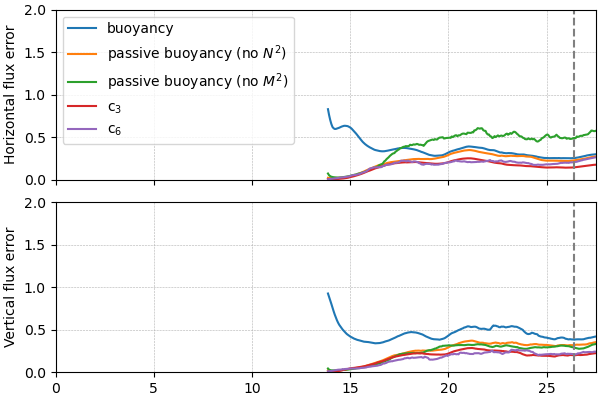

In [6]:
plt.close()
_,ax = plt.subplots(2,1, figsize=(6,4), constrained_layout=True, sharex=True, sharey=True)

ax[0].plot(dsa.timeTf, dsa['⟨uᵢ′bᵝ′⟩_err'].sel(i=1,β='active'))
# ax[0].plot(dsa.timeTf, dsa['⟨uᵢ′bᵝ′⟩_err'].sel(i=1,β='passive'))
ax[0].plot(dsa.timeTf, dsa['⟨uᵢ′cᵐ′⟩_err'].sel(i=1).isel(m=-2))
ax[0].plot(dsa.timeTf, dsa['⟨uᵢ′cᵐ′⟩_err'].sel(i=1).isel(m=-1))
ax[0].plot(dsa.timeTf, dsa['⟨uᵢ′cᵅ′⟩_err'].sel(i=1,α=3))
ax[0].plot(dsa.timeTf, dsa['⟨uᵢ′cᵅ′⟩_err'].sel(i=1,α=6))
ax[0].legend(['buoyancy', r'passive buoyancy (no $N^2$)',
              r'passive buoyancy (no $M^2$)', r'c$_3$', r'c$_6$'],
             frameon=True, loc='upper left')
# ax[0].axvline(dsa.timeTf.isel(time=30), ls='--', c='gray')
# ax[0].axvline(dsa.timeTf.isel(time=itime), ls='--', c='gray')
ax[0].axvline(dsa.timeTf.isel(time=-20), ls='--', c='gray')
ax[0].grid(ls='--', lw=0.4)


ax[1].plot(dsa.timeTf, dsa['⟨uᵢ′bᵝ′⟩_err'].sel(i=3,β='active'))
# ax[1].plot(dsa.timeTf, dsa['⟨uᵢ′bᵝ′⟩_err'].sel(i=3,β='passive'))
ax[1].plot(dsa.timeTf, dsa['⟨uᵢ′cᵐ′⟩_err'].sel(i=3).isel(m=-2))
ax[1].plot(dsa.timeTf, dsa['⟨uᵢ′cᵐ′⟩_err'].sel(i=3).isel(m=-1))
ax[1].plot(dsa.timeTf, dsa['⟨uᵢ′cᵅ′⟩_err'].sel(i=3,α=3))
ax[1].plot(dsa.timeTf, dsa['⟨uᵢ′cᵅ′⟩_err'].sel(i=3,α=6))
# ax[1].axvline(dsa.timeTf.isel(time=30), ls='--', c='gray')
# ax[1].axvline(dsa.timeTf.isel(time=itime), ls='--', c='gray')
ax[1].axvline(dsa.timeTf.isel(time=-20), ls='--', c='gray')
ax[1].grid(ls='--', lw=0.4)

plt.ylim(0,2)
# plt.xlim(7,10)
plt.xlim(0,27.5)
ax[0].set_ylabel('Horizontal flux error')
ax[1].set_ylabel('Vertical flux error');

### Do along-front averaged statistics converge?

In [ ]:
cname = 'c11_M010_Q000_W000_D000_St0_Ri10'
ds = xr.open_dataset(data_dir+cname+'_averages.nc')#.chunk({'time':3, 'zC':16})
ds.close()
ds

In [ ]:
# cname = 'f11_M001_Q000_W000_D000_St0_Ri1'
cname = 'f11_M010_Q000_W000_D000_St0_Ri1'
dsf = xr.open_dataset(data_dir+cname+'_state.nc').isel(time=19)
dsf.close()
# dsa = dsa.where(dsa.zC>=-100, drop=True)
# dsa['timeTf'] = dsa.time/np.timedelta64(int(np.around(2*np.pi/dsa.f)), 's')
dsf

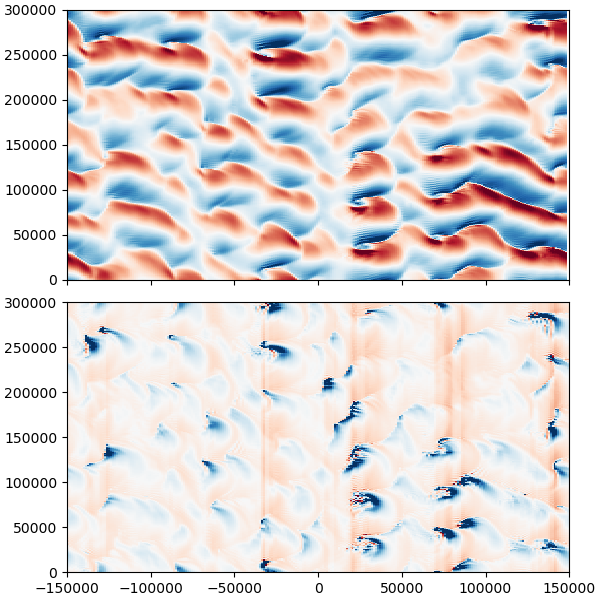

In [58]:
plt.close()
_,ax = plt.subplots(2,1, figsize=(6,6), sharex=True, sharey=True, constrained_layout=True)

uccc = dsf.u.interp(xF=dsf.xC)
u_ym = uccc.mean('yC')
# wccc = dsf.w.interp(zF=dsf.zC)
# w_ym = wccc.mean('yC')

c2_ym = dsf.c2.mean('yC')

pcolor_center((uccc - u_ym).isel(zC=-5),  ax[0])
pcolor_center((dsf.c2 - c2_ym).isel(zC=-5),  ax[1]);
# pcolor_center((uccc - u_ym).isel(zC=40) * (dsf.c2 - c2_ym).isel(zC=40),  ax[1]);

# pcolor_center((wccc.isel(yC=100) - w_ym) * (dsf.c2.isel(yC=100) - c2_ym),  ax[0])
# pcolor_center((wccc.isel(yC=200) - w_ym) * (dsf.c2.isel(yC=200) - c2_ym),  ax[1]);

# pcolor_center(w_ym,  ax[0])
# pcolor_center(c2_ym,  ax[1], sym_mag=1);

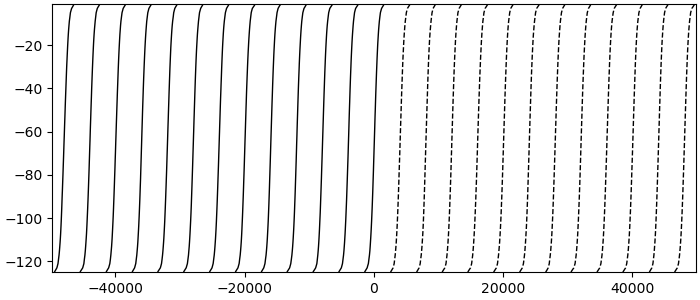

In [23]:
plt.close()
# plt.figure(figsize=(3.2,4.5), constrained_layout=True)
itime = 60

# plt.plot(dsa['⟨u⟩'].mean('xF').isel(time=0), dsa.zC)
# plt.plot(dsa['⟨u⟩'].mean('xF').isel(time=itime), dsa.zC)

# plt.plot(dsa['v_ym'].mean('xC').isel(time=0), dsa.zC)
# plt.plot(dsa['v_ym'].mean('xC').isel(time=itime), dsa.zC)

# plt.plot((dsa['⟨bᵝ⟩']).mean('xC').isel(time=0,β=0), dsa.zC)
# plt.plot((dsa['⟨bᵝ⟩']).mean('xC').isel(time=40,β=0), dsa.zC)
# plt.plot((dsa['⟨bᵝ⟩']).mean('xC').isel(time=70,β=0), dsa.zC)
# plt.plot((dsa['⟨bᵝ⟩']).mean('xC').isel(time=180,β=0), dsa.zC)

# plt.plot((dsa['⟨b⟩']-0e-8*dsa.xC).sel(xC=-400, method='nearest').isel(time=0), dsa.zC)
# plt.plot((dsa['⟨b⟩']-0e-8*dsa.xC).sel(xC=0, method='nearest').isel(time=0), dsa.zC)

tr=4
# plt.plot(dsa['⟨cᵅ⟩'].sel(s=0.5,α=tr).isel(time=0).mean('xC'), dsa.zC)
# plt.plot(dsa['⟨cᵅ⟩'].sel(s=0.5,α=tr).isel(time=40).mean('xC'), dsa.zC)
# plt.plot(dsa['⟨cᵅ⟩'].sel(s=0.5,α=tr).isel(time=70).mean('xC'), dsa.zC)
# plt.plot(dsa['⟨cᵅ⟩'].sel(s=0.5,α=tr).isel(time=160).mean('xC'), dsa.zC)

# plt.plot(dsa['⟨cᵐ⟩'].sel(m=tr).isel(time=0).mean('xC'), dsa.zC)
# plt.plot(dsa['⟨cᵐ⟩'].sel(m=tr).isel(time=40).mean('xC'), dsa.zC)
# plt.plot(dsa['⟨cᵐ⟩'].sel(m=tr).isel(time=70).mean('xC'), dsa.zC)
# plt.plot(dsa['⟨cᵐ⟩'].sel(m=tr).isel(time=180).mean('xC'), dsa.zC)

# plt.grid(ls='--', lw=0.4)
# plt.ylim(-126,0);

plt.figure(figsize=(7,3), constrained_layout=True)
# pcolor_center(ds['w′c4′_ym'].isel(time=itime), plt.gca());
plt.contour(dsa.xC, dsa.zC, (-1e-8*dsa.xC + dsa['⟨bᵝ⟩'].isel(time=itime,β=0)).T, 29, colors='k', linewidths=1);

# iy = 500
# pcolor_center(dsf['c2'].isel(yC=iy), plt.gca())#, sym_mag=1);#-2*dsa.xC/1e3
# plt.contour(dsf.xC, dsf.zC, dsf['b'].isel(yC=iy)-1e-8*dsf.xC, 30, colors='k', linewidths=0.2);

# iz=-30
# plt.figure(figsize=(2,6), constrained_layout=True)
# pcolor_center(dsf['c9'].isel(zC=iz), plt.gca());
# plt.contour(dsf.xC, dsf.yC, dsf['b'].isel(zC=iz)-1e-8*dsf.xC, 10, colors='k', linewidths=0.2);

# plt.gca().set_aspect('equal');

### Gradient patterns, and fluxes comparison: LES vs reconstruction

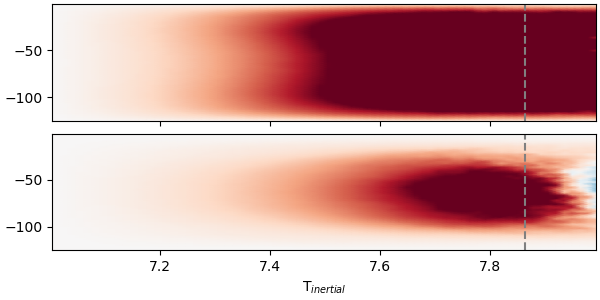

In [7]:
plt.close()
# plt.figure(constrained_layout=True)

itime = 60
# plt.plot(dsa['Kappa'].isel(time=itime,k=0).mean('xC')/np.abs(dsa['Kappa'].isel(time=itime,k=0).mean('xC')).max(), dsa.zC, ':k')
# plt.plot(dsa['Kappa'].isel(time=itime,k=1).mean('xC')/np.abs(dsa['Kappa'].isel(time=itime,k=1).mean('xC')).max(), dsa.zC, '--k')
# plt.plot(dsa['Aᵢⱼ'].isel(time=itime).sel(i=3,j=1).mean('xC')/np.abs(dsa['Aᵢⱼ'].isel(time=itime).sel(i=3,j=1).mean('xC')).max(), dsa.zC, 'g'); # A_31 should be the streamfunction psi
# plt.grid(ls='--', lw=0.4)

# plt.plot(dsa['Sᵢⱼ'].isel(time=itime).sel(i=3,j=3).mean('xC'), dsa.zC);

# plt.pcolormesh(dsa.timeTf, dsa.zC, dsa['Aᵢⱼ'].sel(i=3,j=1).mean('xC').T,
#                shading='gouraud', cmap='RdBu_r', vmax=3e-2, vmin=-3e-2); # A_31 should be the streamfunction psi
# plt.pcolormesh(dsa.timeTf, dsa.zC, dsa['Kappa'].sel(k=2).mean('xC').T,
#                shading='gouraud', cmap='RdBu_r', vmax=3e-2, vmin=-3e-2); 

_,ax = plt.subplots(2,1, figsize=(6,3), constrained_layout=True, sharex=True)
ax[0].pcolormesh(dsa.timeTf, dsa.zC, dsa['Rᵢⱼ'].sel(i=3,j=1).mean('xC'),
               shading='gouraud', cmap='RdBu_r', vmax=5e-2, vmin=-5e-2);
ax[1].pcolormesh(dsa.timeTf, dsa.zC, dsa['Rᵢⱼ'].sel(i=3,j=3).mean('xC'),
               shading='gouraud', cmap='RdBu_r', vmax=5e-2, vmin=-5e-2);
ax[0].axvline(dsa.timeTf.isel(time=itime), ls='--', c='gray')
ax[1].axvline(dsa.timeTf.isel(time=itime), ls='--', c='gray')
plt.xlabel(r'T$_{inertial}$');

# pcolor_center(dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=3), plt.gca());
# pcolor_center(dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=1), plt.gca());

# plt.plot(dsa['Rᵢⱼ'].isel(time=itime).sel(i=1,j=1).mean('xC')/np.abs(dsa['Rᵢⱼ'].isel(time=itime).sel(i=1,j=1).mean('xC')).max(), dsa.zC);
# plt.plot(dsa['Rᵢⱼ'].isel(time=itime).sel(i=1,j=3).mean('xC')/np.abs(dsa['Rᵢⱼ'].isel(time=itime).sel(i=1,j=3).mean('xC')).max(), dsa.zC);
# plt.plot(dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=1).mean('xC')/np.abs(dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=1).mean('xC')).max(), dsa.zC, '--C1');
# plt.plot(dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=3).mean('xC')/np.abs(dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=3).mean('xC')).max(), dsa.zC);
# plt.xlim(-1, 1);

# pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=3) * dsa['∇ⱼ⟨b⟩'].isel(time=itime).sel(j=3), plt.gca());
# pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=1) * dsa['∇ⱼ⟨b⟩'].isel(time=itime).sel(j=1), plt.gca());
# pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=3) * dsa['∇ⱼ⟨b⟩'].isel(time=itime).sel(j=3) +
#               -dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=1) * dsa['∇ⱼ⟨b⟩'].isel(time=itime).sel(j=1), plt.gca());

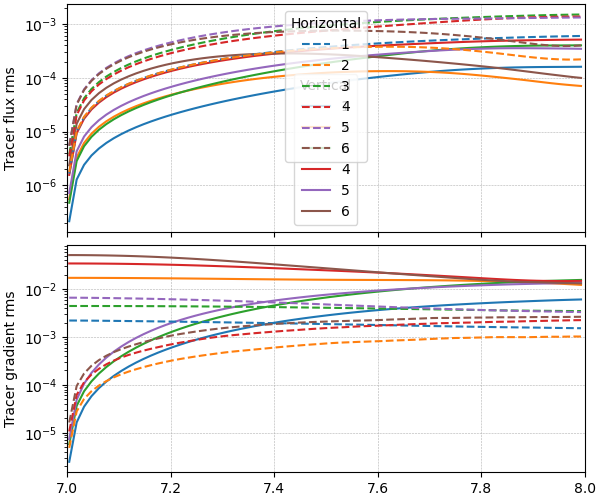

In [9]:
plt.close()
_,ax = plt.subplots(2,1, figsize=(6,5), sharex=True, constrained_layout=True)

for ic in range(1,7):
    ax[0].plot(dsa.timeTf,  np.sqrt((dsa['⟨uᵢ′cᵅ′⟩'].sel(α=ic,i=3)**2).mean(['xC', 'zC'])))
    ax[1].plot(dsa.timeTf, np.sqrt((dsa['∇ⱼ⟨cᵅ⟩'].sel(α=ic,j=3)**2).mean(['xC', 'zC'])))
ax[0].set_prop_cycle(None)
ax[1].set_prop_cycle(None)
line_handles = []
for ic in range(1,7):
    l0, = ax[0].plot(dsa.timeTf,  np.sqrt((dsa['⟨uᵢ′cᵅ′⟩'].sel(α=ic,i=1)**2).mean(['xC', 'zC'])), ls='--')
    line_handles.append(l0)
    ax[1].plot(dsa.timeTf, np.sqrt((dsa['∇ⱼ⟨cᵅ⟩'].sel(α=ic,j=1)**2).mean(['xC', 'zC'])), ls='--')

legend1 = ax[0].legend([f'{i}' for i in range(1,7)], title='Vertical')
ax[0].add_artist(legend1)
ax[0].legend(line_handles, [f'{i}' for i in range(1,7)], title='Horizontal', loc='upper center')
ax[0].grid(ls='--', lw=0.4)
ax[1].grid(ls='--', lw=0.4)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylabel(r'Tracer flux rms')
ax[1].set_ylabel(r'Tracer gradient rms')
plt.xlim(7,8);
# ax[0].set_ylim(1e-4, 1e0)
# ax[1].set_ylim(1e-3, 1e1);

### Diagnose contributions to transport tensor $R_{ij}$ from different tracers

In [36]:
itime = 80
# G = dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime).data
# F = dsa['⟨uᵢ′bᵝ′⟩'].isel(time=itime).data
# G = np.stack((dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime,β=0).data, dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime,m=0).data), axis=-1)
# F = np.stack((dsa['⟨uᵢ′bᵝ′⟩'].isel(time=itime,β=0).data, dsa['⟨uᵢ′cᵐ′⟩'].isel(time=itime,m=0).data), axis=-1)

G = np.stack((dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime,β=0).data, dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime,s=0,α=0).data), axis=-1)
F = np.stack((dsa['⟨uᵢ′bᵝ′⟩'].isel(time=itime,β=0).data, dsa['⟨uᵢ′cᵅ′⟩'].isel(time=itime,s=0,α=0).data), axis=-1)
# G = np.append(dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime,s=0,α=slice(0,1)).data, dsa['∇ⱼ⟨b⟩'].isel(time=itime).data[:,:,:,None], axis=-1)
# F = np.append(dsa['⟨uᵢ′cᵅ′⟩'].isel(time=itime,s=0,α=slice(0,1)).data, dsa['⟨uᵢ′b′⟩'].isel(time=itime).data[:,:,:,None], axis=-1)

G_inv = np.linalg.pinv(G)
R = -np.matmul(F, G_inv)

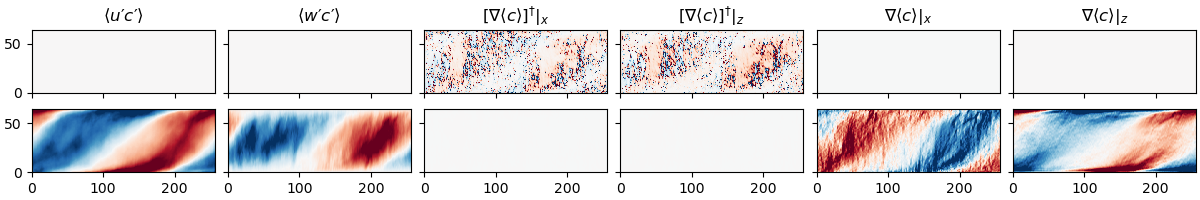

In [37]:
plt.close()
_,ax = plt.subplots(2,6, figsize=(12,2), sharex=True, sharey=True, constrained_layout=True)

mag1 = np.quantile(np.abs(F[:,:,0,:]), 0.97)
mag2 = np.quantile(np.abs(F[:,:,1,:]), 0.97)
mag3 = np.quantile(np.abs(G_inv[:,:,:,0]), 0.97)
mag4 = np.quantile(np.abs(G_inv[:,:,:,1]), 0.97)
mag5 = np.quantile(np.abs(G[:,:,0,:]), 0.97)
mag6 = np.quantile(np.abs(G[:,:,1,:]), 0.97)
for ic in range(2):
    ax[ic,0].pcolormesh(F[:,:,0,ic], cmap='RdBu_r', vmin=-mag1, vmax=mag1)
    ax[ic,1].pcolormesh(F[:,:,1,ic], cmap='RdBu_r', vmin=-mag2, vmax=mag2)
    ax[ic,2].pcolormesh(G_inv[:,:,ic,0], cmap='RdBu_r', vmin=-mag3, vmax=mag3)
    ax[ic,3].pcolormesh(G_inv[:,:,ic,1], cmap='RdBu_r', vmin=-mag4, vmax=mag4)
    ax[ic,4].pcolormesh(G[:,:,0,ic], cmap='RdBu_r', vmin=-mag5, vmax=mag5)
    ax[ic,5].pcolormesh(G[:,:,1,ic], cmap='RdBu_r', vmin=-mag6, vmax=mag6)
ax[0,0].set_title(r'$⟨u′c′⟩$')
ax[0,1].set_title(r'$⟨w′c′⟩$')
ax[0,2].set_title(r'$[∇⟨c⟩]^{\dag}|_x$')
ax[0,3].set_title(r'$[∇⟨c⟩]^{\dag}|_z$')
ax[0,4].set_title(r'$∇⟨c⟩|_x$')
ax[0,5].set_title(r'$∇⟨c⟩|_z$');

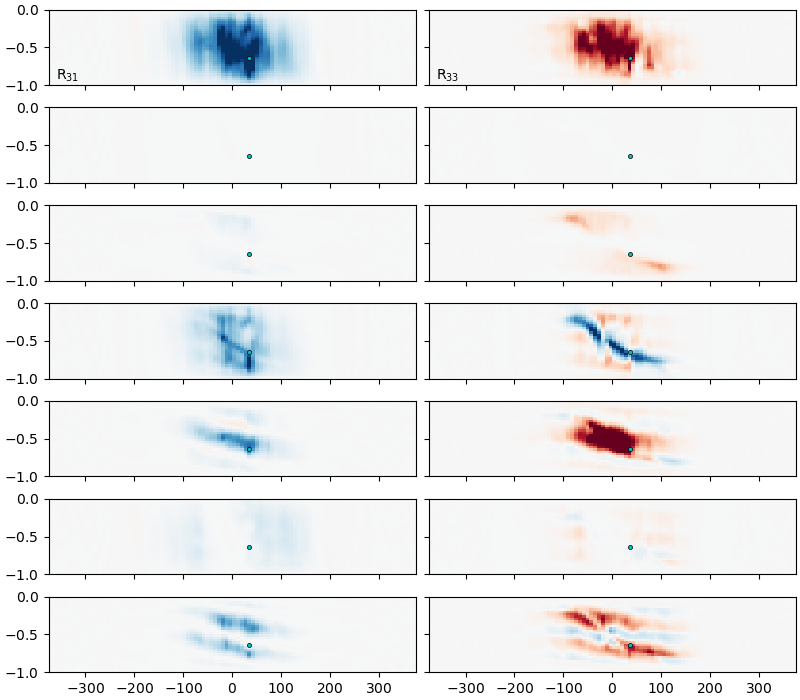

In [16]:
plt.close()
_,ax = plt.subplots(7,2, figsize=(8,7), sharex=True, sharey=True, constrained_layout=True)
# _,ax = plt.subplots(13,2, figsize=(8,8), sharex=True, sharey=True, constrained_layout=True)
itime = -20
ix = 52
iz = 11

mag1h = np.abs(dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=1)).quantile(0.97)
mag1v = np.abs(dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=3)).quantile(0.97)
# mag1 = np.quantile(np.abs(R[:,:,1,:]), 0.97)
# ax[0,0].pcolormesh(dsa.xC, dsa.zC, R[:,:,1,0], cmap='RdBu_r', vmin=-mag1, vmax=mag1)
# ax[0,1].pcolormesh(dsa.xC, dsa.zC, R[:,:,1,1], cmap='RdBu_r', vmin=-mag1, vmax=mag1)
pcolor_center(dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=1), ax[0,0], sym_mag=mag1h)
pcolor_center(dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=3), ax[0,1], sym_mag=mag1v)
ax[0,0].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
ax[0,1].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)

for ic in range(1,7):
    pcolor_center(-dsa['⟨uᵢ′cᵅ′⟩|ⁿ'].isel(time=itime).sel(i=3,α=ic) * dsa['∇ⱼ⟨cᵅ⟩|ⁿ ⁻¹'].isel(time=itime).sel(α=ic,j=1),
                  ax[ic,0], sym_mag=mag1h)
    pcolor_center(-dsa['⟨uᵢ′cᵅ′⟩|ⁿ'].isel(time=itime).sel(i=3,α=ic) * dsa['∇ⱼ⟨cᵅ⟩|ⁿ ⁻¹'].isel(time=itime).sel(α=ic,j=3),
                 ax[ic,1], sym_mag=mag1v)
    ax[ic,0].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
    ax[ic,1].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)

ax[0,0].text(0.02, 0.02, r'R$_{31}$', ha='left', va='bottom', transform=ax[0,0].transAxes)
ax[0,1].text(0.02, 0.02, r'R$_{33}$', ha='left', va='bottom', transform=ax[0,1].transAxes);

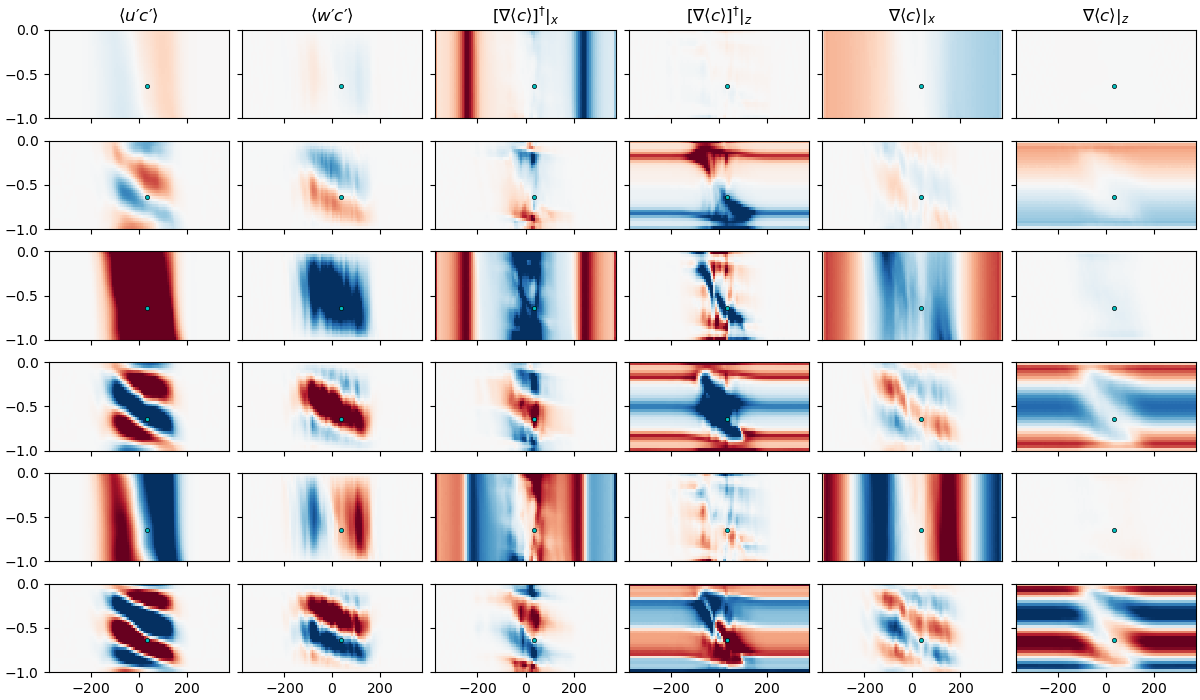

In [17]:
plt.close()
_,ax = plt.subplots(6,6, figsize=(12,7), sharex=True, sharey=True, constrained_layout=True)
itime = -20
ix = 52
iz = 11

mag1h = np.abs(dsa['⟨uᵢ′cᵅ′⟩|ⁿ'].sel(i=1)).quantile(0.97)
mag1z = np.abs(dsa['⟨uᵢ′cᵅ′⟩|ⁿ'].sel(i=3)).quantile(0.97)
mag2h = np.abs(dsa['∇ⱼ⟨cᵅ⟩|ⁿ ⁻¹'].sel(j=1)).quantile(0.97)
mag2z = np.abs(dsa['∇ⱼ⟨cᵅ⟩|ⁿ ⁻¹'].sel(j=3)).quantile(0.97)
mag3h = np.abs(dsa['∇ⱼ⟨cᵅ⟩|ⁿ'].sel(j=1)).quantile(0.97)
mag3z = np.abs(dsa['∇ⱼ⟨cᵅ⟩|ⁿ'].sel(j=3)).quantile(0.97)
for ic in range(1,7):
    pcolor_center(dsa['⟨uᵢ′cᵅ′⟩|ⁿ'].isel(time=itime).sel(i=1,α=ic), ax[ic-1,0], sym_mag=mag1h)
    pcolor_center(dsa['⟨uᵢ′cᵅ′⟩|ⁿ'].isel(time=itime).sel(i=3,α=ic), ax[ic-1,1], sym_mag=mag1z)
    pcolor_center(dsa['∇ⱼ⟨cᵅ⟩|ⁿ ⁻¹'].isel(time=itime).sel(j=1,α=ic), ax[ic-1,2], sym_mag=mag2h)
    pcolor_center(dsa['∇ⱼ⟨cᵅ⟩|ⁿ ⁻¹'].isel(time=itime).sel(j=3,α=ic), ax[ic-1,3], sym_mag=mag2z)
    pcolor_center(dsa['∇ⱼ⟨cᵅ⟩|ⁿ'].isel(time=itime).sel(j=1,α=ic), ax[ic-1,4], sym_mag=mag3h)
    pcolor_center(dsa['∇ⱼ⟨cᵅ⟩|ⁿ'].isel(time=itime).sel(j=3,α=ic), ax[ic-1,5], sym_mag=mag3z)
    ax[ic-1,0].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
    ax[ic-1,1].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
    ax[ic-1,2].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
    ax[ic-1,3].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
    ax[ic-1,4].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
    ax[ic-1,5].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
ax[0,0].set_title(r'$⟨u′c′⟩$')
ax[0,1].set_title(r'$⟨w′c′⟩$')
ax[0,2].set_title(r'$[∇⟨c⟩]^{\dag}|_x$')
ax[0,3].set_title(r'$[∇⟨c⟩]^{\dag}|_z$')
ax[0,4].set_title(r'$∇⟨c⟩|_x$')
ax[0,5].set_title(r'$∇⟨c⟩|_z$');

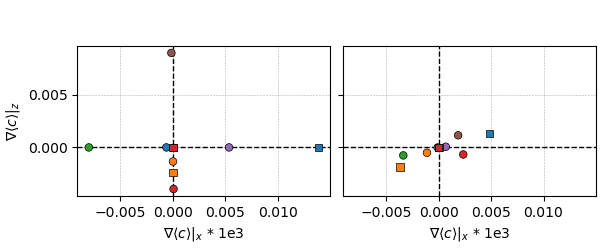

In [18]:
plt.close()
_,ax = plt.subplots(1,2, figsize=(6,2.5), constrained_layout=True, sharex=True, sharey=True)
itime = -20
ix = 52
iz = 11

ax[0].axvline(0, ls='--', lw=1, c='k')
ax[0].axhline(0, ls='--', lw=1, c='k')
ax[0].grid(True, ls='--', lw=0.4)
ax[1].axvline(0, ls='--', lw=1, c='k')
ax[1].axhline(0, ls='--', lw=1, c='k')
ax[1].grid(True, ls='--', lw=0.4)

cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, 10))

ax[0].scatter(dsa['∇ⱼ⟨cᵅ⟩|ⁿ'].isel(time=0, xC=ix, zC=iz).sel(j=1) / 1e-3,
              dsa['∇ⱼ⟨cᵅ⟩|ⁿ'].isel(time=0, xC=ix, zC=iz).sel(j=3) / 1,
              30, c=colors[range(dsa.α.size)], edgecolor='k', zorder=3, linewidths=0.5);
ax[0].scatter(dsa['∇ⱼ⟨cᵐ⟩'].isel(time=0, xC=ix, zC=iz).sel(j=1) / 1e-3,
              dsa['∇ⱼ⟨cᵐ⟩'].isel(time=0, xC=ix, zC=iz).sel(j=3) / 1,
              30, colors[range(dsa.m.size)], marker='s', edgecolor='k', zorder=3, linewidths=0.5);

# grdb_ratio = dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime, xC=ix, zC=iz, β=0).sel(j=3) / dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime, xC=ix, zC=iz, β=0).sel(j=1)
# ax[0].plot([-6e-6, 0, 2e-5], [-6e-6*grdb_ratio, 0, 2e-5*grdb_ratio], 'r')

# grdb_ratio = dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime, xC=ix, zC=iz, β=0).sel(j=3) / dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime, xC=ix, zC=iz, β=0).sel(j=1)
# ax[1].plot([-6e-6, 0, 2e-5], [-6e-6*grdb_ratio, 0, 2e-5*grdb_ratio], 'r')

ax[1].scatter(dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime, xC=ix, zC=iz).sel(j=1) / 1e-3,
              dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime, xC=ix, zC=iz).sel(j=3) / 1,
              30, colors[range(dsa.α.size)], edgecolor='k', zorder=3, linewidths=0.5);

ax[1].scatter(dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime, xC=ix, zC=iz).sel(j=1) / 1e-3,
              dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime, xC=ix, zC=iz).sel(j=3) / 1,
              30, colors[range(dsa.m.size)], marker='s', edgecolor='k', zorder=3, linewidths=0.5);

# tmp = rms_mag.isel(time=itime, xC=ix, zC=iz)
# ax[2].scatter(dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime, xC=ix, zC=iz).sel(j=1) / tmp,
#               dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime, xC=ix, zC=iz).sel(j=3) / tmp,
#               30, dsa.α, 's', cmap='tab10', edgecolor='k', zorder=3, linewidths=0.5);

# plt.xlim(-1, 1.1)
# plt.ylim(-1.1, 1.1);

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_xlabel(r'$∇⟨c⟩|_x$ * 1e3')
ax[1].set_xlabel(r'$∇⟨c⟩|_x$ * 1e3')
ax[0].set_ylabel(r'$∇⟨c⟩|_z$ ');

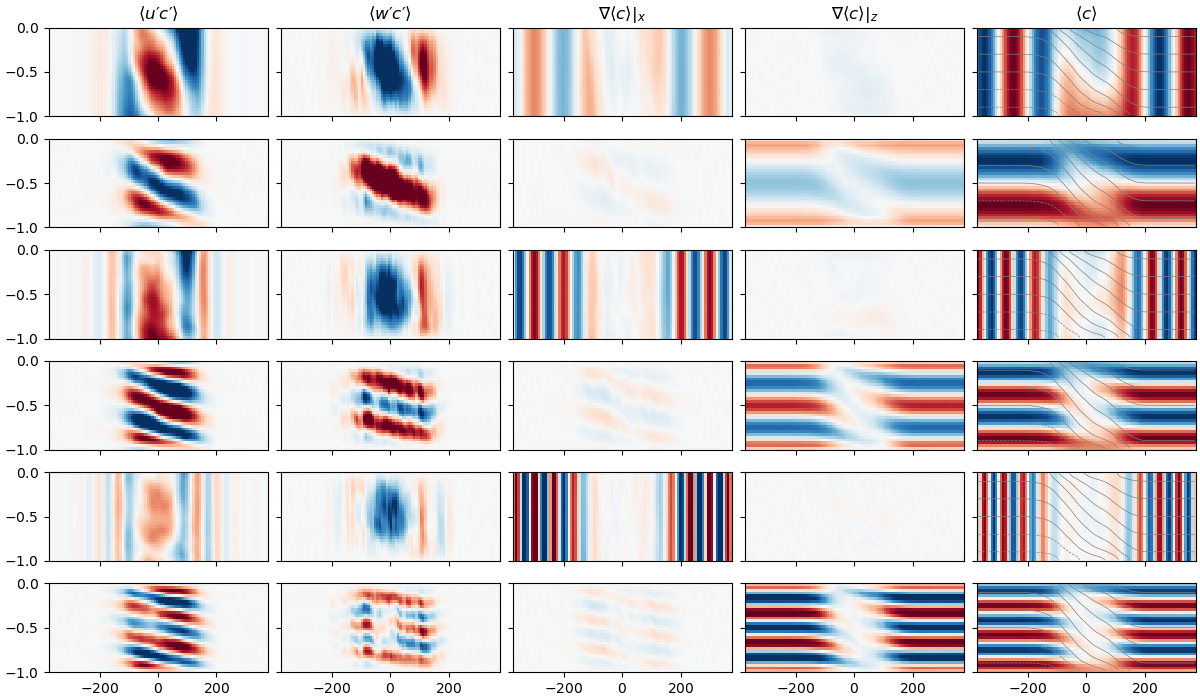

In [10]:
plt.close()
_,ax = plt.subplots(6,5, figsize=(12,7), sharex=True, sharey=True, constrained_layout=True)
itime = -20

mag1h = np.abs(dsa['⟨uᵢ′cᵅ′⟩|ⁿ'].isel(time=itime).sel(i=1)).quantile(0.97)
mag1v = np.abs(dsa['⟨uᵢ′cᵅ′⟩|ⁿ'].isel(time=itime).sel(i=3)).quantile(0.97)
# mag2 = np.abs(dsa['∇ⱼ⟨cᵅ⟩|ⁿ ⁻¹'].isel(time=itime)).quantile(0.97)
mag3h = np.abs(dsa['∇ⱼ⟨cᵅ⟩|ⁿ'].isel(time=itime).sel(j=1)).quantile(0.97)
mag3v = np.abs(dsa['∇ⱼ⟨cᵅ⟩|ⁿ'].isel(time=itime).sel(j=3)).quantile(0.97)
for ic in range(1,7):
    pcolor_center(dsa['⟨uᵢ′cᵅ′⟩|ⁿ'].isel(time=itime).sel(i=1,α=ic), ax[ic-1,0], sym_mag=mag1h)
    pcolor_center(dsa['⟨uᵢ′cᵅ′⟩|ⁿ'].isel(time=itime).sel(i=3,α=ic), ax[ic-1,1], sym_mag=mag1v)
    pcolor_center(dsa['∇ⱼ⟨cᵅ⟩|ⁿ'].isel(time=itime).sel(j=1,α=ic), ax[ic-1,2], sym_mag=mag3h)
    pcolor_center(dsa['∇ⱼ⟨cᵅ⟩|ⁿ'].isel(time=itime).sel(j=3,α=ic), ax[ic-1,3], sym_mag=mag3v)
    # pcolor_center(np.arctan2(dsa['∇ⱼ⟨cᵅ⟩|ⁿ'].isel(time=itime).sel(j=3,α=ic),
    #                          dsa['∇ⱼ⟨cᵅ⟩|ⁿ'].isel(time=itime).sel(j=1,α=ic))*180/np.pi, ax[ic-1,4], sym_mag=180)
    pcolor_center(dsa['⟨cᵅ⟩'].isel(time=itime).sel(α=ic)-0*dsa.xC/1e3, ax[ic-1,4], sym_mag=1)
    ax[ic-1,4].contour(dsa.xC, dsa.zC, dsa['⟨bᵝ⟩'].isel(time=itime,β=0), levels=10, linewidths=0.5, colors='gray')

ax[0,0].set_title(r'$⟨u′c′⟩$')
ax[0,1].set_title(r'$⟨w′c′⟩$')
ax[0,2].set_title(r'$∇⟨c⟩|_x$')
ax[0,3].set_title(r'$∇⟨c⟩|_z$')
ax[0,4].set_title(r'$⟨c⟩$');
# ax[0,4].set_title(r'$arctan(∇⟨c⟩|_z, ∇⟨c⟩|_x)$');

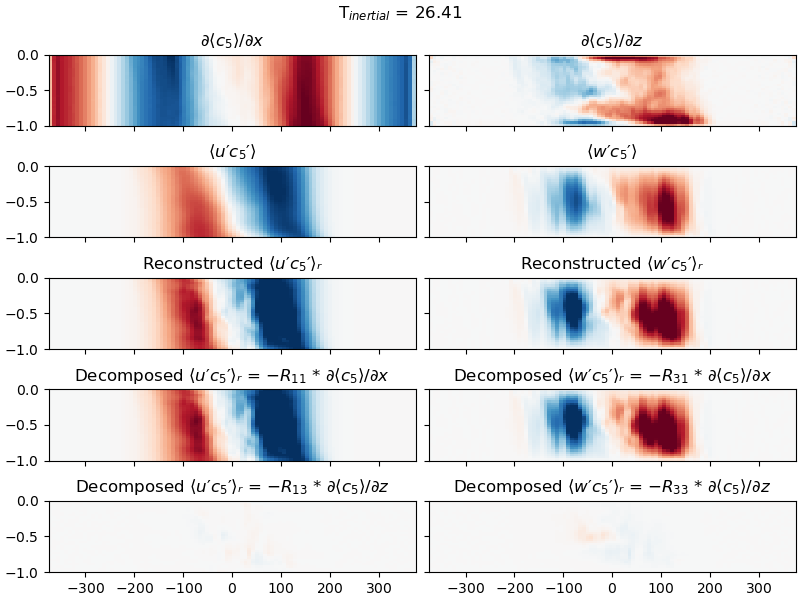

In [15]:
plt.close()
_,ax = plt.subplots(5,2, figsize=(8,6), sharey=True, constrained_layout=True, sharex='col')

itime = -20
tr = 5

grd_magh = np.abs(dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime).sel(α=tr,j=1)).quantile(0.99)
grd_magv = np.abs(dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime).sel(α=tr,j=3)).quantile(0.99)
pcolor_center(dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime).sel(j=1, α=tr), ax[0,0], sym_mag=grd_magh)
ax[0,0].set_title(rf'$\partial ⟨c_{tr}⟩/\partial x$')

pcolor_center(dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime).sel(j=3, α=tr), ax[0,1], sym_mag=grd_magv)
ax[0,1].set_title(rf'$\partial ⟨c_{tr}⟩/\partial z$');

# pcolor_center(dsa['⟨cᵅ⟩'].isel(time=itime).sel( α=tr), ax[0,0])
# ax[0,0].set_title(rf'$\partial ⟨c_{tr}⟩/\partial x$')
# pcolor_center(dsa['⟨cᵅ⟩'].isel(time=itime).sel( α=tr), ax[0,1], sym_mag=1)
# ax[0,1].set_title(rf'$\partial ⟨c_{{{tr}}}⟩/\partial z$');

flx_magh = np.abs(dsa['⟨uᵢ′cᵅ′⟩'].isel(time=itime).sel(α=tr,i=1)).quantile(0.99)
flx_magv = np.abs(dsa['⟨uᵢ′cᵅ′⟩'].isel(time=itime).sel(α=tr,i=3)).quantile(0.99)
pcolor_center(dsa['⟨uᵢ′cᵅ′⟩'].isel(time=itime).sel(i=1, α=tr), ax[1,0], sym_mag=flx_magh)
ax[1,0].set_title(rf'$⟨u′c_{tr}′⟩$')
pcolor_center(dsa['⟨uᵢ′cᵅ′⟩'].isel(time=itime).sel(i=3, α=tr), ax[1,1], sym_mag=flx_magv)
ax[1,1].set_title(rf'$⟨w′c_{tr}′⟩$');

pcolor_center(dsa['⟨uᵢ′cᵅ′⟩ᵣ'].isel(time=itime).sel(i=1, α=tr), ax[2,0], sym_mag=flx_magh)
ax[2,0].set_title(rf'Reconstructed $⟨u′c_{tr}′⟩ᵣ$')
pcolor_center(dsa['⟨uᵢ′cᵅ′⟩ᵣ'].isel(time=itime).sel(i=3, α=tr), ax[2,1], sym_mag=flx_magv)
ax[2,1].set_title(rf'Reconstructed $⟨w′c_{tr}′⟩ᵣ$');

pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=1,j=1) * dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime).sel(j=1,α=tr), ax[3,0], sym_mag=flx_magh)
ax[3,0].set_title(rf'Decomposed $⟨u′c_{tr}′⟩ᵣ$ = $-R_{{11}}$ * $\partial ⟨c_{tr}⟩/\partial x$')
pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=1) * dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime).sel(j=1,α=tr), ax[3,1], sym_mag=flx_magv)
ax[3,1].set_title(rf'Decomposed $⟨w′c_{tr}′⟩ᵣ$ = $-R_{{31}}$ * $\partial ⟨c_{tr}⟩/\partial x$')

pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=1,j=3) * dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime).sel(j=3,α=tr), ax[4,0], sym_mag=flx_magh)
ax[4,0].set_title(rf'Decomposed $⟨u′c_{tr}′⟩ᵣ$ = $-R_{{13}}$ * $\partial ⟨c_{tr}⟩/\partial z$')
pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=3) * dsa['∇ⱼ⟨cᵅ⟩'].isel(time=itime).sel(j=3,α=tr), ax[4,1], sym_mag=flx_magv);
ax[4,1].set_title(rf'Decomposed $⟨w′c_{tr}′⟩ᵣ$ = $-R_{{33}}$ * $\partial ⟨c_{tr}⟩/\partial z$')

plt.suptitle(f'T$_{{inertial}}$ = {dsa.timeTf.isel(time=itime).data:.2f}');

In [ ]:
plt.close()
plt.figure()
plt.plot(-dsa['⟨uᵢ′cᵅ′⟩ᵣ'].sel(xC=-50,zC=-50, method='nearest').isel(time=itime), -dsa['⟨uᵢ′cᵅ′⟩'].sel(xC=-50,zC=-50, method='nearest').isel(time=itime),'o')
plt.plot(-dsa['⟨uᵢ′b′⟩ᵣ'].sel(xC=-50,zC=-50, method='nearest').isel(time=itime), -dsa['⟨uᵢ′b′⟩'].sel(xC=-50,zC=-50, method='nearest').isel(time=itime),'s')
plt.gca().set_aspect('equal')
plt.xscale('symlog', linthresh=1e-12)
plt.yscale('symlog', linthresh=1e-12)
plt.grid('on', ls='--', c='gray');

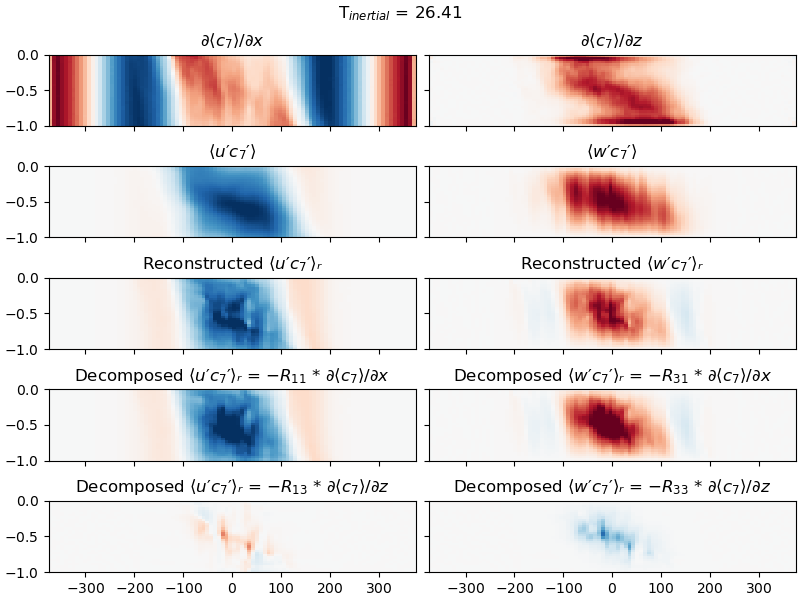

In [13]:
plt.close()
_,ax = plt.subplots(5,2, figsize=(8,6), sharey=True, constrained_layout=True, sharex='col')

itime = -20
tr = 7

grd_magh = np.abs(dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(m=tr,j=1)).quantile(0.99)
grd_magv = np.abs(dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(m=tr,j=3)).quantile(0.99)
pcolor_center(dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(j=1, m=tr), ax[0,0], sym_mag=grd_magh)
ax[0,0].set_title(rf'$\partial ⟨c_{{{tr}}}⟩/\partial x$')
pcolor_center(dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(j=3, m=tr), ax[0,1], sym_mag=grd_magv)
ax[0,1].set_title(rf'$\partial ⟨c_{{{tr}}}⟩/\partial z$');

flx_magh = np.abs(dsa['⟨uᵢ′cᵐ′⟩'].isel(time=itime).sel(m=tr,i=1)).quantile(0.99)
flx_magv = np.abs(dsa['⟨uᵢ′cᵐ′⟩'].isel(time=itime).sel(m=tr,i=3)).quantile(0.99)
pcolor_center(dsa['⟨uᵢ′cᵐ′⟩'].isel(time=itime).sel(i=1, m=tr), ax[1,0], sym_mag=flx_magh)
ax[1,0].set_title(rf'$⟨u′c_{{{tr}}}′⟩$')
pcolor_center(dsa['⟨uᵢ′cᵐ′⟩'].isel(time=itime).sel(i=3, m=tr), ax[1,1], sym_mag=flx_magv)
ax[1,1].set_title(rf'$⟨w′c_{{{tr}}}′⟩$');

# flux_r = -np.matmul(R, dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(m=tr).data[:,:,:,None])
pcolor_center(dsa['⟨uᵢ′cᵐ′⟩ᵣ'].isel(time=itime).sel(i=1, m=tr), ax[2,0], sym_mag=flx_magh)
# ax[2,0].pcolormesh(dsa.xC, dsa.zC, flux_r[:,:,0,0], cmap='RdBu_r', vmin=-flx_mag, vmax=flx_mag)
ax[2,0].set_title(rf'Reconstructed $⟨u′c_{{{tr}}}′⟩ᵣ$')
pcolor_center(dsa['⟨uᵢ′cᵐ′⟩ᵣ'].isel(time=itime).sel(i=3, m=tr), ax[2,1], sym_mag=flx_magv)
# ax[2,1].pcolormesh(dsa.xC, dsa.zC, flux_r[:,:,1,0], cmap='RdBu_r', vmin=-flx_mag, vmax=flx_mag)
ax[2,1].set_title(rf'Reconstructed $⟨w′c_{{{tr}}}′⟩ᵣ$');

pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=1,j=1) * dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(j=1,m=tr), ax[3,0], sym_mag=flx_magh)
# pcolor_center(-R[:,:,0,0] * dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(j=1,m=tr), ax[3,0], sym_mag=flx_mag)
ax[3,0].set_title(rf'Decomposed $⟨u′c_{{{tr}}}′⟩ᵣ$ = $-R_{{11}}$ * $\partial ⟨c_{{{tr}}}⟩/\partial x$')
pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=1) * dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(j=1,m=tr), ax[3,1], sym_mag=flx_magv)
# pcolor_center(-R[:,:,1,0] * dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(j=1,m=tr), ax[3,1], sym_mag=flx_mag)
ax[3,1].set_title(rf'Decomposed $⟨w′c_{{{tr}}}′⟩ᵣ$ = $-R_{{31}}$ * $\partial ⟨c_{{{tr}}}⟩/\partial x$')

pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=1,j=3) * dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(j=3,m=tr), ax[4,0], sym_mag=flx_magh)
# pcolor_center(-R[:,:,0,1] * dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(j=3,m=tr), ax[4,0], sym_mag=flx_mag)
ax[4,0].set_title(rf'Decomposed $⟨u′c_{{{tr}}}′⟩ᵣ$ = $-R_{{13}}$ * $\partial ⟨c_{{{tr}}}⟩/\partial z$')
pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=3) * dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(j=3,m=tr), ax[4,1], sym_mag=flx_magv)
# pcolor_center(-R[:,:,1,1] * dsa['∇ⱼ⟨cᵐ⟩'].isel(time=itime).sel(j=3,m=tr), ax[4,1], sym_mag=flx_mag)
ax[4,1].set_title(rf'Decomposed $⟨w′c_{{{tr}}}′⟩ᵣ$ = $-R_{{33}}$ * $\partial ⟨c_{{{tr}}}⟩/\partial z$')

plt.suptitle(f'T$_{{inertial}}$ = {dsa.timeTf.isel(time=itime).data:.2f}');

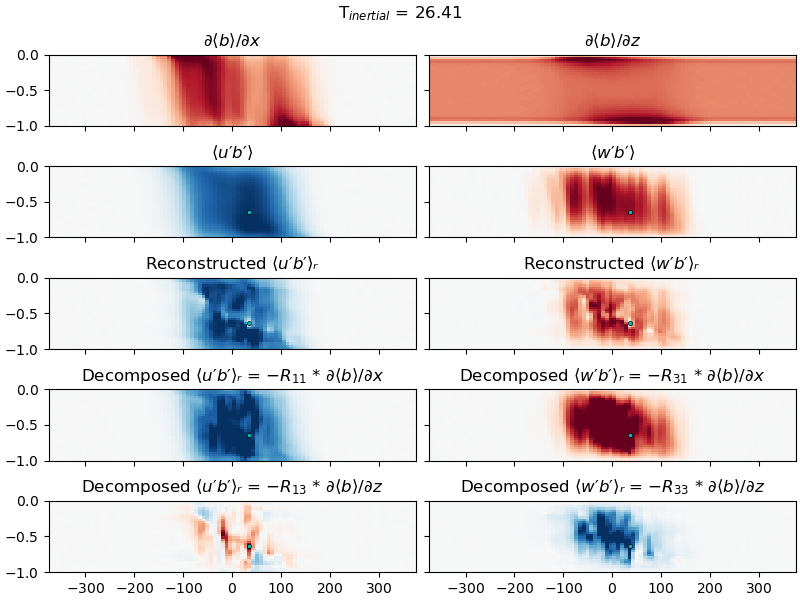

In [9]:
plt.close()
_,ax = plt.subplots(5,2, figsize=(8,6), sharey=True, constrained_layout=True, sharex=True)

itime = -20
ix = 52
iz = 11
trb = 'active'
# trb = 'passive'

grd_magh = np.abs(dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime).sel(β=trb,j=1)).quantile(0.99)
grd_magv = np.abs(dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime).sel(β=trb,j=3)).quantile(0.99)
pcolor_center(dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime).sel(j=1,β=trb), ax[0,0], sym_mag=grd_magh)
ax[0,0].set_title(r'$\partial ⟨b⟩/\partial x$')
pcolor_center(dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime).sel(j=3,β=trb), ax[0,1], sym_mag=grd_magv)
ax[0,1].set_title(r'$\partial ⟨b⟩/\partial z$')

flx_magh = np.abs(dsa['⟨uᵢ′bᵝ′⟩'].isel(time=itime).sel(β=trb,i=1)).quantile(0.99)
flx_magv = np.abs(dsa['⟨uᵢ′bᵝ′⟩'].isel(time=itime).sel(β=trb,i=3)).quantile(0.99)
pcolor_center(dsa['⟨uᵢ′bᵝ′⟩'].isel(time=itime).sel(i=1,β=trb), ax[1,0], sym_mag=flx_magh)
ax[1,0].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
ax[1,0].set_title(r'$⟨u′b′⟩$')
pcolor_center(dsa['⟨uᵢ′bᵝ′⟩'].isel(time=itime).sel(i=3,β=trb), ax[1,1], sym_mag=flx_magv)
ax[1,1].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
ax[1,1].set_title(r'$⟨w′b′⟩$')

# flux_r = -np.matmul(R, dsa['∇ⱼ⟨b⟩'].isel(time=itime).data[:,:,:,None])
pcolor_center(dsa['⟨uᵢ′bᵝ′⟩ᵣ'].isel(time=itime).sel(i=1,β=trb), ax[2,0], sym_mag=flx_magh)
# ax[2,0].pcolormesh(dsa.xC, dsa.zC, flux_r[:,:,0,0], cmap='RdBu_r', vmin=-flx_mag, vmax=flx_mag)
ax[2,0].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
ax[2,0].set_title(r'Reconstructed $⟨u′b′⟩ᵣ$')
pcolor_center(dsa['⟨uᵢ′bᵝ′⟩ᵣ'].isel(time=itime).sel(i=3,β=trb), ax[2,1], sym_mag=flx_magv)
# ax[2,1].pcolormesh(dsa.xC, dsa.zC, flux_r[:,:,1,0], cmap='RdBu_r', vmin=-flx_mag, vmax=flx_mag)
ax[2,1].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
ax[2,1].set_title(r'Reconstructed $⟨w′b′⟩ᵣ$');

pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=1,j=1) * dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime).sel(j=1,β=trb), ax[3,0], sym_mag=flx_magh)
ax[3,0].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
# pcolor_center(-R[:,:,0,0] * dsa['∇ⱼ⟨b⟩'].isel(time=itime).sel(j=1), ax[3,0], sym_mag=flx_mag)
ax[3,0].set_title(rf'Decomposed $⟨u′b′⟩ᵣ$ = $-R_{{11}}$ * $\partial ⟨b⟩/\partial x$')
pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=1) * dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime).sel(j=1,β=trb), ax[3,1], sym_mag=flx_magv)
ax[3,1].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
# pcolor_center(-R[:,:,1,0] * dsa['∇ⱼ⟨b⟩'].isel(time=itime).sel(j=1), ax[3,1], sym_mag=flx_mag)
ax[3,1].set_title(rf'Decomposed $⟨w′b′⟩ᵣ$ = $-R_{{31}}$ * $\partial ⟨b⟩/\partial x$')

pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=1,j=3) * dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime).sel(j=3,β=trb), ax[4,0], sym_mag=flx_magh)
ax[4,0].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
# pcolor_center(-R[:,:,0,1] * dsa['∇ⱼ⟨b⟩'].isel(time=itime).sel(j=3), ax[4,0], sym_mag=flx_mag)
ax[4,0].set_title(rf'Decomposed $⟨u′b′⟩ᵣ$ = $-R_{{13}}$ * $\partial ⟨b⟩/\partial z$')
pcolor_center(-dsa['Rᵢⱼ'].isel(time=itime).sel(i=3,j=3) * dsa['∇ⱼ⟨bᵝ⟩'].isel(time=itime).sel(j=3,β=trb), ax[4,1], sym_mag=flx_magv)
ax[4,1].plot(dsa.xC.isel(xC=ix), dsa.zC.isel(zC=iz), 'oc', mec='k', mew=0.5, ms=3)
# pcolor_center(-R[:,:,1,1] * dsa['∇ⱼ⟨b⟩'].isel(time=itime).sel(j=3), ax[4,1], sym_mag=flx_mag)
ax[4,1].set_title(rf'Decomposed $⟨w′b′⟩ᵣ$ = $-R_{{33}}$ * $\partial ⟨b⟩/\partial z$')

plt.suptitle(f'T$_{{inertial}}$ = {dsa.timeTf.isel(time=itime).data:.2f}');

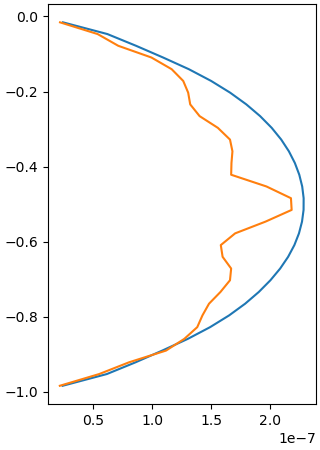

In [12]:
plt.close()
plt.figure(figsize=(3.2,4.5), constrained_layout=True)
itime = -20
plt.plot(dsa['⟨uᵢ′bᵝ′⟩'].isel(time=itime).sel(i=3,β=trb).mean('xC'), dsa.zC)
plt.plot(dsa['⟨uᵢ′bᵝ′⟩ᵣ'].isel(time=itime).sel(i=3,β=trb).mean('xC'), dsa.zC);

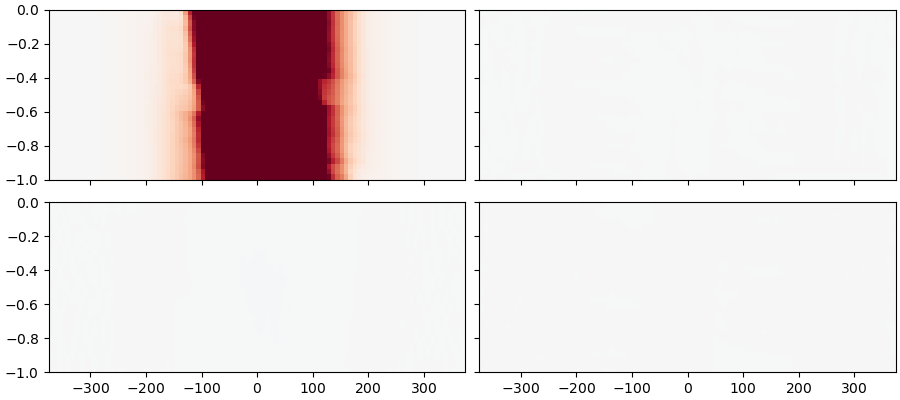

In [13]:
plt.close()
_,ax = plt.subplots(2,2, figsize=(9,4), sharey=True, constrained_layout=True, sharex='col')

itime = slice(-20,None)
mag1 = np.linalg.norm(dsa['Rᵢⱼ'].isel(time=itime).data, axis=(-2,-1)).mean()
pcolor_center(dsa['Rᵢⱼ'].isel(time=itime).mean('time').sel(i=1,j=1), ax[0,0], sym_mag=mag1)
pcolor_center(dsa['Rᵢⱼ'].isel(time=itime).mean('time').sel(i=1,j=3), ax[0,1], sym_mag=mag1)
pcolor_center(dsa['Rᵢⱼ'].isel(time=itime).mean('time').sel(i=3,j=1), ax[1,0], sym_mag=mag1)
pcolor_center(dsa['Rᵢⱼ'].isel(time=itime).mean('time').sel(i=3,j=3), ax[1,1], sym_mag=mag1);

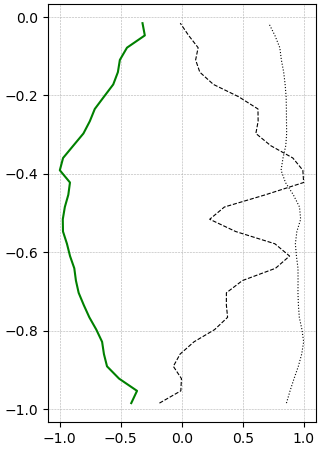

In [15]:
plt.close()
plt.figure(figsize=(3.2,4.5), constrained_layout=True)

itime = slice(-20,None)
plt.plot(dsa['Kappa'].isel(time=itime,k=0).mean(['xC','time'])/np.abs(dsa['Kappa'].isel(time=itime,k=0).mean(['xC','time'])).max(), dsa.zC, ':k', lw=0.8)
plt.plot(dsa['Kappa'].isel(time=itime,k=1).mean(['xC','time'])/np.abs(dsa['Kappa'].isel(time=itime,k=1).mean(['xC','time'])).max(), dsa.zC, '--k', lw=0.8)
plt.plot(dsa['Aᵢⱼ'].isel(time=itime).sel(i=3,j=1).mean(['xC','time'])/np.abs(dsa['Aᵢⱼ'].isel(time=itime).sel(i=3,j=1).mean(['xC','time'])).max(), dsa.zC, 'g'); # A_31 should be the streamfunction psi
plt.grid(ls='--', lw=0.4);

### Make movies to compare flux evolution

In [ ]:
USER = os.getenv('USER')
TMPDIR = f'/glade/derecho/scratch/{USER}/temp'
job_script_prologue = ['export TMPDIR=/glade/scratch/derecho/$USER/temp', 'mkdir -p $TMPDIR']
cluster_kw = dict(job_name=cname+'_plot_slices',
                  cores=1,
                  memory='4GiB',
                  processes=1,
                  local_directory=f'{TMPDIR}/pbs.$PBS_JOBID/dask/spill',
                  log_directory=f'{TMPDIR}/pbs.$PBS_JOBID/dask/worker_logs',
                  job_extra_directives=['-j oe', '-A UMCP0036'],
                  job_script_prologue=job_script_prologue,
                  resource_spec='select=1:ncpus=1:mem=4GB',
                  queue='casper',
                  walltime='30:00',
                  interface='ext')
cluster =  PBSCluster(**cluster_kw)
client = Client(cluster)
print(cluster.job_script())
cluster.scale(8)
# print(cluster.dashboard_link.replace(':8787', ':1212/proxy/42843'))

In [ ]:
%%time
stream([(dsa['⟨uᵢ′cᵅ′⟩'].sel(i=1).isel(time=itime),  dsa['⟨uᵢ′b′⟩'].sel(i=1).isel(time=itime), 
         dsa['⟨uᵢ′cᵅ′⟩ᵣ'].sel(i=1).isel(time=itime), dsa['⟨uᵢ′b′⟩ᵣ'].sel(i=1).isel(time=itime)) for itime in range(1,210)],
       renderer=plot_flux_comparison,
       max_frames=-1,
       client=client,
       renderer_iterables=[dsa.timeTf.data],
       renderer_kwargs=dict(title_str='u'),
       write_kwargs=dict(crf='18'),
      ).write(cname+'_horizontal_flux_comparison.mp4');
cluster.close()

In [ ]:
%%time
stream([(dsa['⟨uᵢ′cᵅ′⟩'].sel(i=3).isel(time=itime),  dsa['⟨uᵢ′b′⟩'].sel(i=3).isel(time=itime), 
         dsa['⟨uᵢ′cᵅ′⟩ᵣ'].sel(i=3).isel(time=itime), dsa['⟨uᵢ′b′⟩ᵣ'].sel(i=3).isel(time=itime)) for itime in range(1,210)],
       renderer=plot_flux_comparison,
       max_frames=-1,
       # client=client,
       renderer_iterables=[dsa.timeTf.data],
       renderer_kwargs=dict(title_str='w'),
       write_kwargs=dict(crf='18'),
      ).write(cname+'_vertical_flux_comparison.mp4');

In [ ]:
cluster.close()

In [ ]:
%%time
stream([(dsa['⟨uᵢ′bᵝ′⟩'].isel(time=itime, β=0), 
         dsa['⟨uᵢ′bᵝ′⟩ᵣ'].isel(time=itime, β=0),
         dsa['⟨uᵢ′cᵐ′⟩'].isel(time=itime, m=-1), 
         dsa['⟨uᵢ′cᵐ′⟩ᵣ'].isel(time=itime, m=-1)) for itime in range(dsa.time.size)],
       renderer=plot_flux_comparison_unused,
       max_frames=-1,
       # client=client,
       renderer_iterables=[dsa.timeTf.data],
       write_kwargs=dict(crf='18'),
       renderer_kwargs=dict(coord_unit='km'),
       threads_per_worker=1,
      ).write(cname+'_flux_comparison_unused.mp4');
cluster.close()

In [ ]:
%%time
stream([(dsf.v.isel(time=i,zC=-5), dsf.b.isel(time=i,zC=-5), dsf.c3.isel(time=i,zC=-5), dsf.c4.isel(time=i,zC=-5),
         dsf.v.isel(time=i,yF=256), dsf.b.isel(time=i,yC=256), dsf.c3.isel(time=i,yC=256), dsf.c4.isel(time=i,yC=256)) \
        for i in range(10)],
       renderer=plot_slices,
       max_frames=-1,
       client=client,
       renderer_iterables=[dsf.timeTf.data],
       write_kwargs=dict(crf='18'),
      ).write(cname+'_slices_test.mp4');
cluster.close()